# Предсказание оттока клиентов финтес-центра

Цели и задачи: 
* Спрогнозировать вероятность оттока клиентов в следующем месяце
* Выделить группы клиентов и описать их свойства
* Проанализировать признаки, влияющие на отток
* Сделать выводы и предложить рекомендации по снижению оттока и взаимодействию с клиентами. 

Данные: данные заказчика, которые содержат данные на месяц до оттока и факт оттока на определённый месяц 

* [Шаг 1. Загрузка данных](#one)
* [Шаг 2. Исследовательский анализ данных (EDA)](#two)
* [Шаг 3. Модель прогнозирования оттока клиентов](#three)
* [Шаг 4. Кластеризация клиентов](#four)
* [Шаг 5. Выводы и базовые рекомендации](#five)

## Шаг 1. Загрузка данных<a class="anchor" id="one"></a>

Импортируем все необходимые библиотеки

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
import itertools

Посмотрим на данные

In [ ]:
data = pd.read_csv('/datasets/gym_churn.csv')
data.sample()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1531,0,0,1,0,1,6,0,25,156.921813,2.0,1,2.044484,1.652034,1


Переведем названия колонок в lower case

In [ ]:
data.columns = data.columns.str.lower()
data.sample()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3775,0,1,1,0,1,1,1,27,151.84822,1.0,12,4.226185,4.185463,0


## Шаг 2. Исследовательский анализ данных (EDA) <a class="anchor" id="three"></a>

Оценим чистоту данных

In [ ]:
def reviewer (df):
    print('Общая информация')
    print(df.info())
    print()
    print('Количество дубликатов', df.duplicated().sum())
    print()
    print('Средние значения и стандартные отклонения')
    print(df.describe())

reviewer(data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000

В данных нет пропусков и дубликатов

Посмотрим на средние значения признаков для тех, кто ушел, и тех, кто остался.

In [ ]:
churn = data.groupby('churn').mean()
churn = churn.round(decimals=2)
churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Отличия уходящих <br> * по гендеру и оставлению телефона нет отличий;  <br> * чаще живут дальше, реже приходят от друзей, реже работают в компаниях-парнерах, абонементы чаще на месяц, а не на полгода-год, реже ходят на групповые, в среднем моложе, меньше оставляют денег на дополнительные товары, реже в неделю ходят в зал и к моменту ухода посещаемость в неделю ещё падает 

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [ ]:
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

<Figure size 360x360 with 0 Axes>

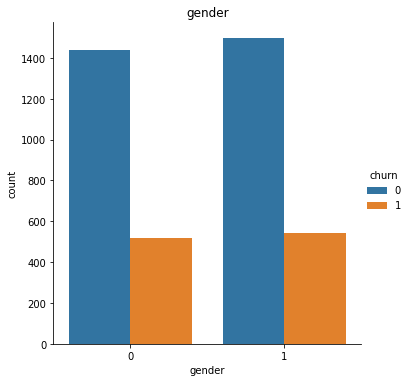

<Figure size 360x360 with 0 Axes>

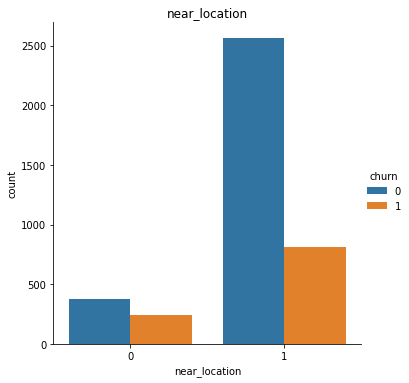

<Figure size 360x360 with 0 Axes>

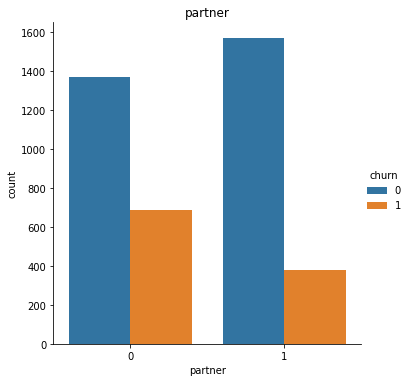

<Figure size 360x360 with 0 Axes>

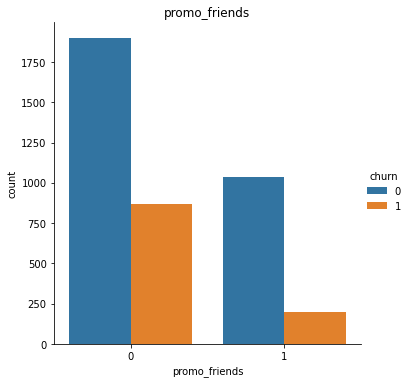

<Figure size 360x360 with 0 Axes>

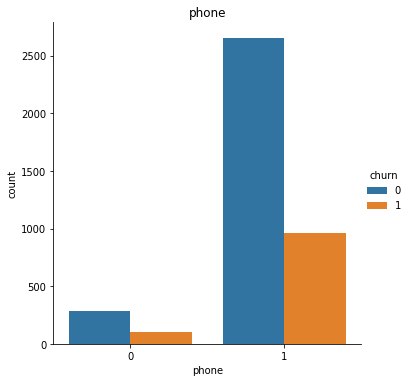

<Figure size 360x360 with 0 Axes>

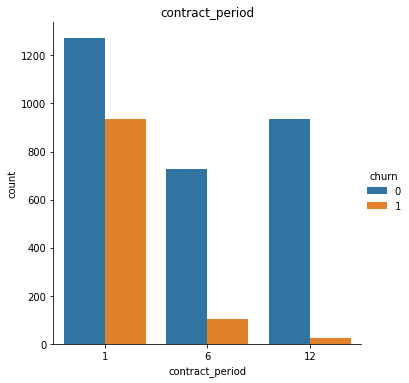

<Figure size 360x360 with 0 Axes>

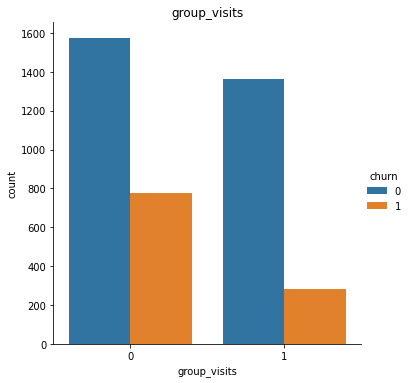

<Figure size 360x360 with 0 Axes>

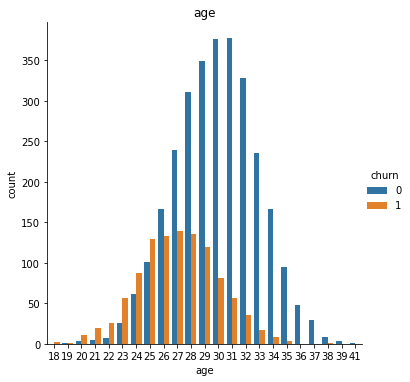

In [ ]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age']:
    plt.figure(figsize=(5, 5))
    sns.catplot(x = column, hue='churn', kind='count', data=data)
    plt.title(column)
    plt.show()



По графикам видно, что оттекающие почти всегда заключают контракт на месяц. Лояльные тоже частенько заключают на месяц, но их больше, чем оттекающих, в контрактах на 6 и 12 месяцев. Наглядно видно, что лояльные немного постарше, чаще имеют партнерские скидки и дружеские приглашения, чаще ходят на групповые занятия. Те, кто живет близко, чаще лояльны. Но некоторое количество близкоживущих оттекает - на них можно осредоточиться отделу маркетинга.

Построим матрицу корреляций признаков

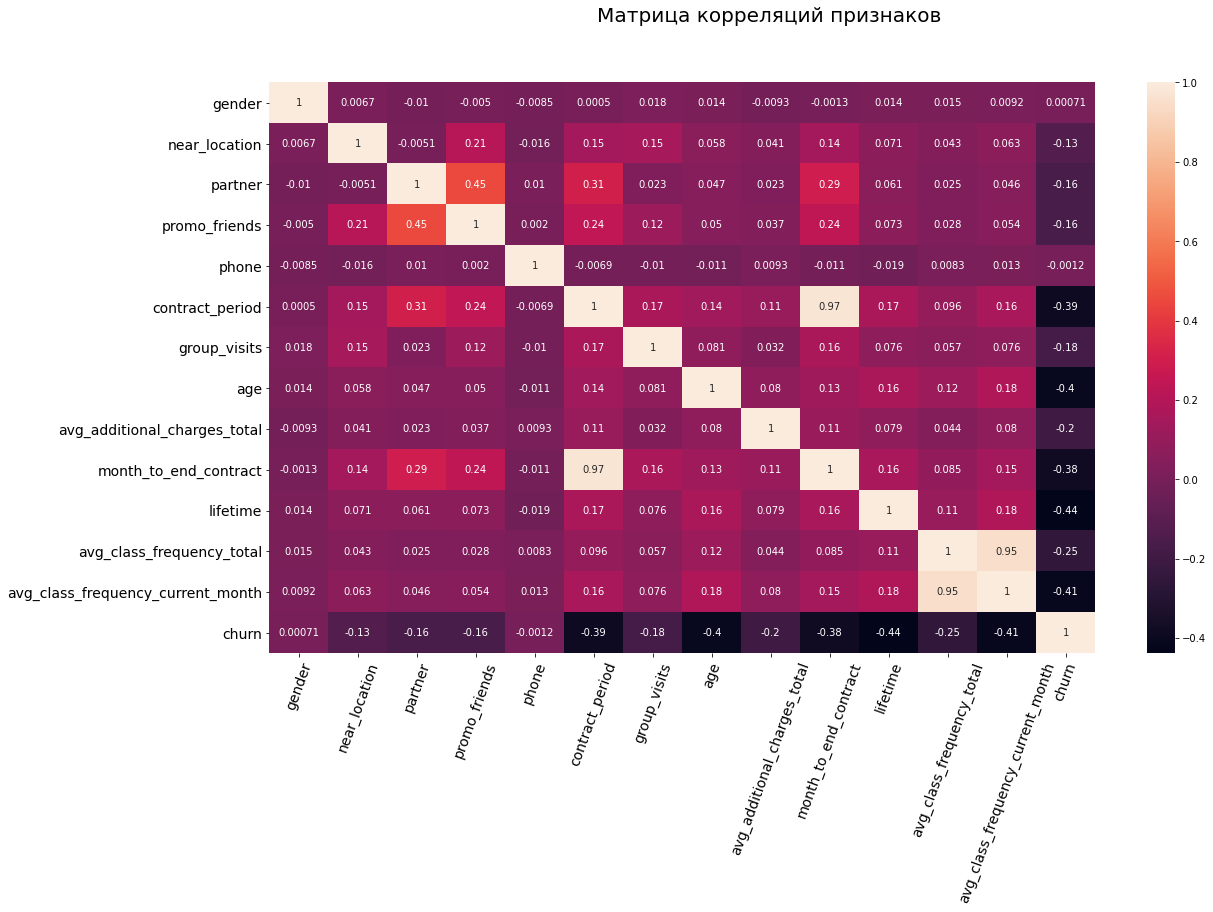

In [ ]:
cm = data.corr() 
fig = plt.figure()
fig.suptitle('Матрица корреляций признаков', fontsize=20)
fig.set_size_inches(18.5, 10.5)
sns.heatmap(data=cm, annot=True)
plt.xticks(fontsize=14, rotation=70)
plt.yticks(fontsize=14)
plt.show()

По ней видно, что сильно коррелируют попарно между собой и с целевым признаком признаки "Месяцев до конца контракта" и "Контрактный период", а также "Средняя посещаемость зала" и "Средняя посещаемость зала в текущем месяце". 
Совсем не коррелируют с целевым гендер и оставление номера телефона.

## Шаг 3. Модель прогнозирования оттока клиентов <a class="anchor" id="three"></a>

У нас есть мультиколлинеарные признаки. Можно убрать ['month_to_end_contract'] и ['avg_class_frequency_total']

In [ ]:
data = data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

Разделим выборку на обучающую и валидационную.

In [ ]:
X = data.drop('churn', axis =1)
y = data['churn']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

Стандартизируем признаки

In [ ]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модели и выберем лучшую

In [ ]:
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0),
    CatBoostClassifier(random_state=0, verbose=False),
]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision: {:.2f} Recall:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )
#цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)
Accuracy:0.92 Precision: 0.86 Recall:0.83 
RandomForestClassifier(random_state=0)
Accuracy:0.91 Precision: 0.87 Recall:0.80 
Accuracy:0.91 Precision: 0.86 Recall:0.81 


Хороши все модели. На первом месте LogisticRegression, потом CatBoost, потом RandomForestClassifier. Если поиграть с параметрами, наверняка можно получить ещё более хорошие результаты.

## Шаг 4. Кластеризация клиентов <a class="anchor" id="four"></a>

У нас уже есть данные без целевого признака. Стандартизируем их, построим матрицу расстояний и визуализируем её в дендрограмме. По ней будет видно, сколько кластеров - групп пользователей - получилось.

In [ ]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеры культуристов-датасаентистов')
plt.show() 

Явно видно 4 кластера. Очевидно четвертый очень большой, и его можно разбить на два. Принимаем n за 5. Обучим модель и посмотрим на среднее для всех признаков.

In [ ]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc) 
data['cluster_km'] = labels
mean_km = data.groupby(['cluster_km']).mean()
mean_km.round(decimals = 2)
mean_km

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


Построим распределения признаков для кластеров. 

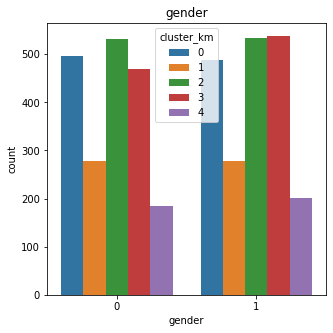

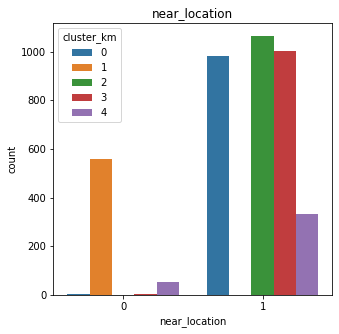

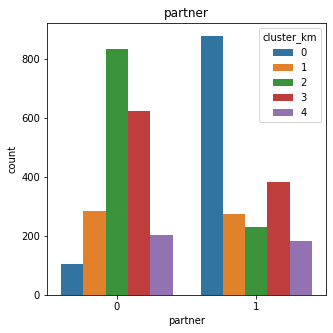

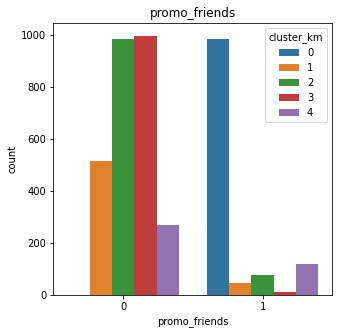

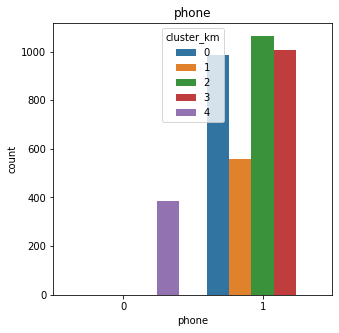

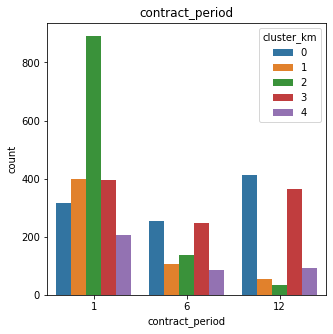

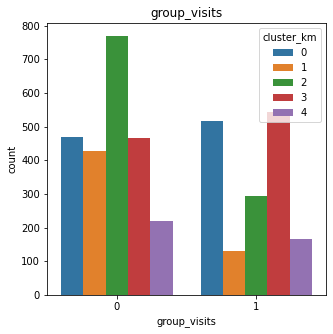

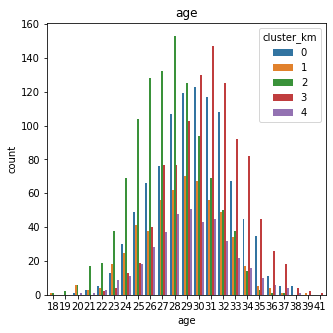

In [ ]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = column, hue='cluster_km', data=data)
    plt.title(column)
    plt.show()

Видно, что в первом кластере люди, которые живут далеко. Поскольку отток в первом кластере большой, очевидно, что это важно. Люди из второго кластера чаще всего заключают контракт на месяц (и отток во втором кластере большой). Несмотря на это, люди из третьего - самого надежного - кластера, заключают контракты на месяц, полгода и год в равной пропорции. Скорее всего, не нужно стимулировать людей покупать абонементы больше, чем на месяц.

Для каждого полученного кластера посчитаем долю оттока

In [ ]:
churn_km = data.groupby(['cluster_km'])['churn'].mean().sort_values()
churn_km.round(decimals = 2)

cluster_km
3    0.01
0    0.12
4    0.27
1    0.40
2    0.56
Name: churn, dtype: float64

Третий кластер самый надежный. Больше всего отток в первом и втором кластерах.

## Шаг 5. Выводы и базовые рекомендации <a class="anchor" id="five"></a>

Изначально отток клиентов составляет около 27%. <br> Анализ данных показывает, что лояльные клиенты в среднем на пару лет старше тех, кто уходит, чаще ближе живут, пользуются дружескими приглашениями и партнерскими программами. Посещают занятия чаще - как минимум 2 раза в неделю, и ходят на групповые.<br> Клиентов можно разделить на 4-5 групп. В двух из них отток довольно большой. В одной из них - скорее всего, потому, что люди далеко живут. Поэтому в первую очередь нужно сосредоточиться на втором кластере, там люди живут близко, но все равно оттекают. Можно предложить им скидки, возможно, бесплатное посещение групповых занятий или хорошие скидки на сопутствующие товары. Тем, кто живёт далеко, можно предложить удаленные групповые занятия или удаленные занятия с персональным тренером.